In [3]:
import pandas as pd

#### chicago TNP reformatting


In [16]:
import pandas as pd
chi_tnp_2018_22 = pd.read_csv("Chigaco_data/Chi_TNP/Transportation_Network_Providers_-_Trips__2018_-_2022_13_12.csv")
chi_tnp_2019_23 = pd.read_csv("Chigaco_data/Chi_TNP/Transportation_Network_Providers_-_Trips__2023-_.csv")

In [17]:
# concatenate the two dataframes
chi_tnp = pd.concat([chi_tnp_2018_22, chi_tnp_2019_23], ignore_index=True)

In [18]:
chi_tnp.rename(columns={'Trip Start Timestamp':'date_pickup' , 'Pickup Community Area' : 'PULocationID' , 'Trip Miles' : 'trip_distance' , 'Fare' : 'total_amount' , 'Trip ID' : 'trip_number'}, inplace=True)

In [19]:

# convert date_pickup to datetime and only keep the date
chi_tnp['date_pickup'] = pd.to_datetime(chi_tnp['date_pickup']).dt.date

C:\Users\max-admin\AppData\Local\Temp\ipykernel_19292\260744647.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chi_tnp['date_pickup'] = pd.to_datetime(chi_tnp['date_pickup']).dt.date


In [20]:

chi_grouped_by_day = chi_tnp.groupby(["date_pickup", "PULocationID"]).agg({"trip_distance": ["mean"], "total_amount": ["mean"], "trip_number": ["sum"] , "Tip" : ["mean"] })
chi_grouped_by_day.columns = ["trip_distance_mean", "total_amount_mean", "trip_number" , "tip_mean"]


In [21]:
chi_grouped_by_day.reset_index(inplace=True)

In [24]:
chi_grouped_by_day.to_csv("Chigaco_data/Chi_TNP/Chi_TNP_Trips_grouped_by_day_2018_2023.csv", index=False)

#### Add climate variables

In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import holidays
from matplotlib.cbook import boxplot_stats 

In [126]:
climate = pd.read_csv("Chigaco_data/CHI_weather_2018-2023.csv")
covid_stringency = pd.read_csv("Covid_Stringency/owid-covid-data.csv")


# prepare covid stringency control

climate["DATE"] = pd.to_datetime(climate["DATE"]).dt.date

covid_stringency = pd.read_csv("Covid_Stringency/owid-covid-data.csv")
covid_stringency_usa = covid_stringency[covid_stringency["iso_code"] == "USA"]
covid_control = covid_stringency_usa[["date","stringency_index"]]
covid_control['date'] = pd.to_datetime(covid_control['date']).dt.date



# merge with climate data
climate_covid = pd.merge(climate, covid_control, how='left', left_on='DATE', right_on='date')
climate_covid.drop(columns=["date"], inplace=True)
# fillup missing covid stringency with 0
climate_covid.fillna(0, inplace=True)

C:\Users\max-admin\AppData\Local\Temp\ipykernel_19292\111397698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_control['date'] = pd.to_datetime(covid_control['date']).dt.date


In [130]:
def fahrenheit_to_celsius(f):
        return (f - 32) * 5/9


def process_chicago():
    """
    Merges aggregated chicago cab date with weather data and creates a csv file for
    further analysis
    
    input: PU_or_DO: string, either "PU" or "DO"    
    
    """


    trips = pd.read_csv(f"Chigaco_data/Chi_TNP/Chi_TNP_trips_grouped_by_day_2018_2023.csv")
    climate = pd.read_csv("Chigaco_data/CHI_weather_2018-2023_covid.csv")



    # sort by date
    trips = trips.sort_values(by=['date_pickup']).reset_index(drop=True)
    # drop Nas
    trips = trips.dropna()
    # convert pickup_community_area to int

    trips['PULocationID'] = trips['PULocationID'].astype(int)

    # only keep date of the date time format column
    trips['date_pickup'] = trips['date_pickup'].str.split(' ').str[0]

    # merge trips and climate data on date
    trips = pd.merge(trips, climate, how='left', left_on='date_pickup', right_on='DATE')

    us_holidays = holidays.US()

    # Create a new column indicating whether each date is a holiday or not
    trips['holiday'] = trips['date_pickup'].apply(lambda x: 1 if x in us_holidays else 0)


    # Apply the conversion function to the Fahrenheit column
    trips['TMAX'] = trips['TMAX'].apply(fahrenheit_to_celsius)

    # add a weekday index to the dataframe starting with Mondays = 0 tuesdays = 1 etc.
    trips['Weekday_index'] = pd.to_datetime(trips['date_pickup']).dt.dayofweek

    taxi_data = trips

    taxi_data.rename(columns={ 'TMAX' : 'tmax_obs'}, inplace=True)


    # add month and year factors
    taxi_data['Year_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.year)[0] + 1
    taxi_data['Month_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.month)[0] + 1
    # log the dependent variable
    taxi_data['log_total'] = np.log(taxi_data['trip_number'] + 1)
    # remove NAs
    taxi_data = taxi_data.dropna(subset=['tmax_obs'])

    num_days = len(taxi_data["date_pickup"].unique())
    
    taxi_data['cheby_0'] = 1
    taxi_data['cheby_1'] = taxi_data['date_pickup'].rank(method='dense').astype(int)/num_days
   
    
    # recursively defining other chebyshev polynomials for each day until 5th order
    for i in range(2, 6):
        taxi_data[f"cheby_{i}"] = (2  * taxi_data["cheby_1"] * taxi_data[f"cheby_{i-1}"]) - taxi_data[f"cheby_{i-2}"]

    # outlier filtering
    out_weekdays = pd.DataFrame()
    filtered_weekdays = pd.DataFrame()
    counter = 1
    for z in taxi_data[f'PULocationID'].unique():
        zcta_data = taxi_data[taxi_data['PULocationID'] == z]
        for w in taxi_data['Weekday_index'].unique():
            zcta_weekday = zcta_data[zcta_data['Weekday_index'] == w]
            out = np.ravel(boxplot_stats(zcta_weekday['log_total'])[0]['fliers'])
            out_ids = np.where(np.isin(zcta_weekday['log_total'], out))[0]
            out_df = zcta_weekday.iloc[out_ids]
            zcta_filtered = zcta_weekday = zcta_weekday.drop(out_df.index)
            if counter == 1:
                out_weekdays = out_df
                filtered_weekdays = zcta_filtered
            else:
                out_weekdays = pd.concat([out_weekdays, out_df])
                filtered_weekdays = pd.concat([filtered_weekdays, zcta_filtered])
            counter += 1


    taxi_data_cut.to_csv("Chigaco_data/chicago_TNP2019_regression.csv", index=False)

In [131]:
process_chicago()

In [133]:
taxi_check = pd.read_csv('Chigaco_data/chicago_TNP2019_regression.csv') 
taxi_check["stringency_index"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: stringency_index, dtype: float64

In [38]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

In [143]:
def binned_regression_plots(city,outcome,temp_bin_size):
        
        ## 1. DATA PREPARATION

      
        if city == "CHI":
                taxi_data_cut = pd.read_csv('Chigaco_data/chicago_TNP2019_regression.csv') 


        sequence_bins = np.arange(-10, 41, temp_bin_size)
        temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
        taxi_data_cut['temp_bins'] = temp_bins

        taxi_data_cut["log_trip_count"] = np.log(taxi_data_cut["trip_number"] + 1)

        # rename bins so linearmodels can handle them

        taxi_data_cut['temp_bins'] = pd.Categorical(taxi_data_cut['temp_bins'], ordered=False).astype(str)
        # rename bins so linearmodels can handle them
        taxi_data_cut['temp_bins'] = taxi_data_cut['temp_bins'].str.replace('\(', '[', regex=True)
        # Create a panel data structure
        taxi_data_cut["date_pickup"] = pd.to_datetime(taxi_data_cut["date_pickup"])
        panel_data = taxi_data_cut.set_index(['PULocationID', 'Year_fact'])
        panel_data = panel_data[panel_data['temp_bins'] != 'nan']


        # For plotting and ommitting the bin with highest number of days

        # Create a new DataFrame with unique days
        unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

        # Count the occurrences of each bin, respecting the categorical order
        temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()

        # Only plot bins with more than one day
        temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
        # Find the index of the maximum count
        max_days_bin = temp_bin_counts.idxmax()

        ##  2. REGRESSIONS

        if city == "CHI":
                if outcome == "trip_number":
                        model_formula = f'log_trip_count ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND  + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results1 = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results1.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "trip_distance_mean":
                        model_formula = f'avg_trip_miles ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + stringency_index + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'avg_trip_miles ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "mean_fare":
                        model_formula = f'avg_fare ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'avg_fare ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)


        ## 3. PLOTS

        coefficients = results.params
        conf_int = results.conf_int()

        # Combine coefficients and confidence intervals into a single DataFrame
        df = pd.DataFrame(pd.concat([coefficients, conf_int], axis=1))
        df.columns = ['Coefficient', 'Lower CI', 'Upper CI']
        df.reset_index(inplace=True)

        # only keep rows where index starts with C(temp_bins)
        df = df[df['index'].str.startswith('C(temp_bins')]

        # extract temperature bin string

        df['Temperature'] = df['index'].str.split(r'\[T\.').str[1].str[:-1]

        df.drop(columns=['index'], inplace=True)

        # Convert Temperature intervals into numerical values
        df['Temperature'] = df['Temperature'].str.strip('[]').str.split(',').apply(lambda x: (float(x[0]) + float(x[1])) / 2)
        # order the dataframe by temperature
        df = df.sort_values(by=['Temperature'])

        # convert the coeffients into percentages and adapt CI accordingly - only with log outcome
        if outcome == "trip_number":
                df['Coefficient'] = df['Coefficient'] * 100
                df['Lower CI'] = df['Lower CI'] * 100
                df['Upper CI'] = df['Upper CI'] * 100

        # Extract Temperature and Coefficient values
        temperature = df['Temperature']
        coefficient = df['Coefficient']

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

        # Create the plot

        ax1.scatter(temperature, coefficient, color='blue', label='Data')
        if outcome == "trip_number":    
                ax1.set_ylabel(f'{outcome} response in %')
        else:
                ax1.set_ylabel(f'{outcome} response in $')
        
        ax1.set_title(f'{outcome} response by {temp_bin_size}°C bin- {city}- 2019-2023 - Community Zone and Year fixed effects')

        # Add confidence intervals if needed
        lower_ci = df['Lower CI']
        upper_ci = df['Upper CI']
        ax1.errorbar(temperature, coefficient, yerr=[coefficient - lower_ci, upper_ci - coefficient], fmt='o', color='red' , capsize= 3,  barsabove = True , label='Confidence Interval')

        # Fit a polynomial
        degree = 2
        coefficients_poly = np.polyfit(temperature, coefficient, degree)
        y_poly = np.polyval(coefficients_poly, temperature)

        # Plot the polynomial curve
        ax1.plot(temperature, y_poly, label=f'Polynomial Fit (Degree {degree})', color='green')

        # add a dotted line at 0 percent
        ax1.axhline(y=0, color='blue', linestyle='--')

        # Add a legend
        ax1.legend()


        sequence_bins = np.arange(-10, 41, temp_bin_size)
        temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
        taxi_data_cut['temp_bins'] = temp_bins
        # Create a new DataFrame with unique days
        unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

        # Count the occurrences of each bin, respecting the categorical order
        temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()
        temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
        # Find the index of the maximum count
        max_days_bin = temp_bin_counts.idxmax()

        # Create a color array with 'grey' for all bars and 'red' for the bar with the maximum count
        color_bin= '(' + max_bin[1:]
        colors = ['grey' if str(bin) != color_bin else 'red' for bin in temp_bin_counts.index]

        # Ensure the plot respects the categorical order
        temp_bin_counts.plot(kind='bar', color=colors)
        ax2.set_title(f' Days in each {temp_bin_size}°C bin- {city} 2019')
        ax2.set_xlabel('Temperature Bins')
        ax2.set_ylabel('Number of Days')
        ax2.tick_params(axis='x', rotation=45)
        print(f"Done: {city} {outcome} {temp_bin_size}")
        print(results)

Done: CHI trip_number 3
                          PanelOLS Estimation Summary                           
Dep. Variable:              log_total   R-squared:                        0.1157
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              138677   R-squared (Within):               0.3742
Date:                Wed, Dec 13 2023   R-squared (Overall):              0.0386
Time:                        18:05:58   Log-likelihood                -2.886e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      788.46
Entities:                          77   P-value                           0.0000
Avg Obs:                       1801.0   Distribution:               F(23,138572)
Min Obs:                       1801.0                                           
Max Obs:                       1801.0   F-statistic (robust):             894.64
    

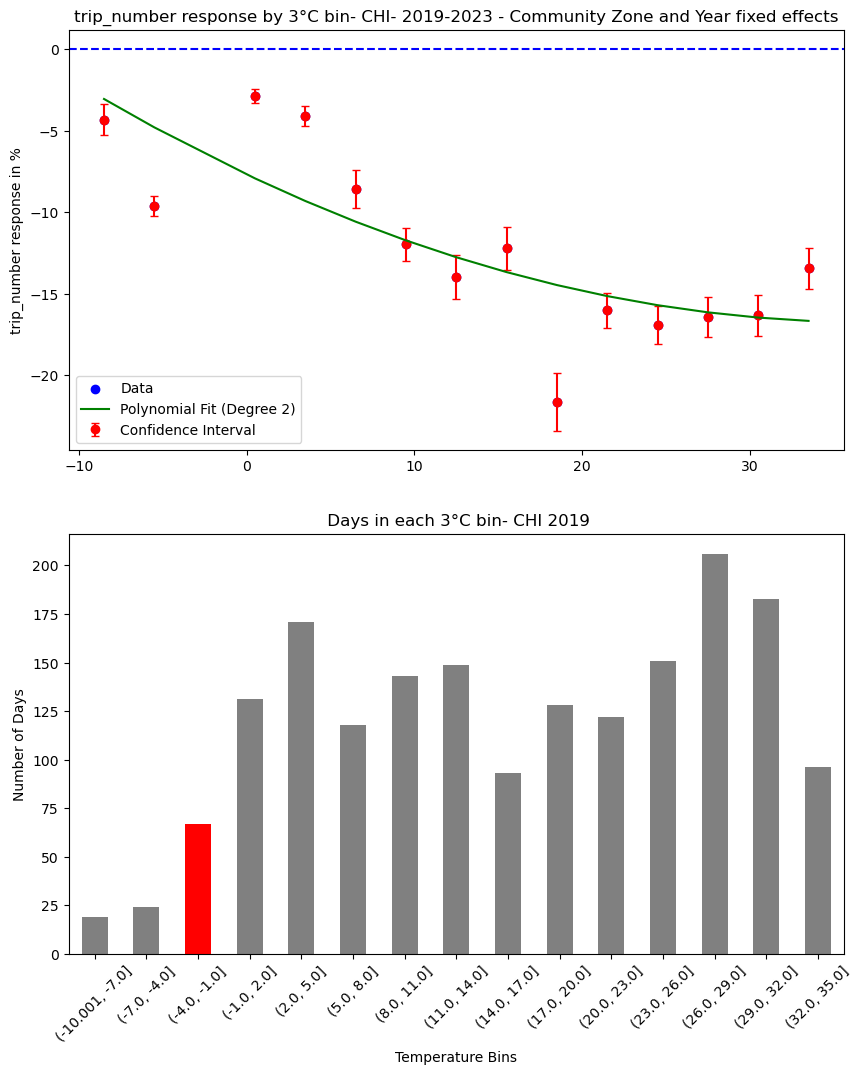

In [146]:
binned_regression_plots("CHI","trip_number",3)

In [8]:
panel_data = pd.read_csv("Chigaco_data/chicago_TNP2019_regression.csv")

In [11]:
import statsmodels.api as sm
def run_zone_level_regression(data, PULocationID):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.
    """
    # Subset the data for the current PULocationID
    temp_data = data[data['PULocationID'] == PULocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {PULocationID}.")
    for col in ["tmax_obs", "log_total", "PRCP"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {PULocationID}.")
    
    

    
    model_formula = 'log_total ~ 1+  tmax_obs + PRCP + AWND  + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'

    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        'PULocationID': PULocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
    }

# Load the data over 20 degrees
panel_data =panel_data[panel_data["tmax_obs"] >= 20]

# Get unique PULocationIDs and apply the regression function to each
unique_ids = panel_data['PULocationID'].unique()
results = [run_zone_level_regression(panel_data, id) for id in unique_ids]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a new CSV file
results_df.to_csv('Chigaco_data/Community_Zone_Results_PU_count.csv', index=False)


### get significant results (over 1) and plot them on the chicago map

In [4]:
import fiona
import geopandas as gpd
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\geopandas\_compat.py:152: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\max-admin\AppData\Local\Temp\ipykernel_24712\2276651184.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [11]:
zone_results = pd.read_csv("Chigaco_data/Community_Zone_Results_PU_count.csv")
zone_results["PULocationID"] = zone_results["PULocationID"].astype(str)
ca = gpd.read_file("Chigaco_data/boundaries_community_areas_chicago.geojson")
ca = ca.set_index('area_num_1')
ca.reset_index(level=0, inplace=True)
ca.head()

zoneresults_shape = ca.merge(zone_results, left_on='area_num_1', right_on = "PULocationID", how='left')
zoneresults_shape = zoneresults_shape[zoneresults_shape["p_value_tmax_obs"] < 0.1]


C:\Users\max-admin\AppData\Local\Temp\ipykernel_24712\1271673164.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(negative_zones.geometry.centroid.x, negative_zones.geometry.centroid.y)]


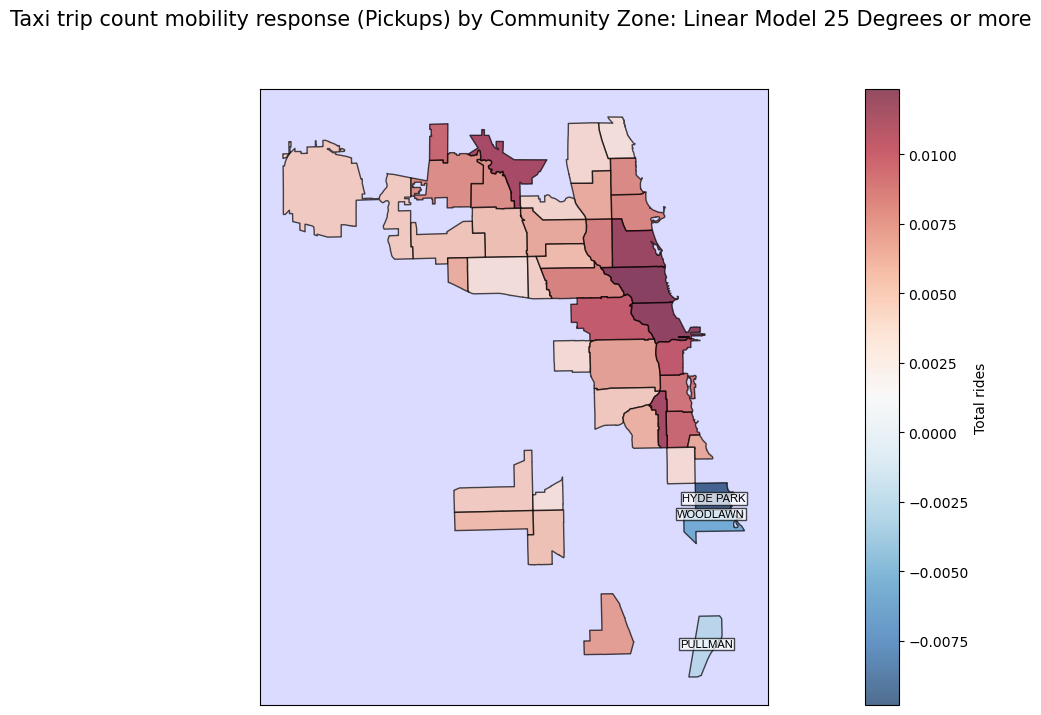

In [12]:
# Sort the DataFrame by 'Coefficient_tmax_obs' in descending order and get the top 5 zones
negative_zones = zoneresults_shape.sort_values('Coefficient_tmax_obs', ascending=True).head(3)

# Plot the data with more transparent facecolor
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
zoneresults_shape.plot(column='Coefficient_tmax_obs', ax=ax, cmap='RdBu_r', legend=False, edgecolor="black", alpha=0.7,
                       norm=colors.TwoSlopeNorm(vcenter=0))  # Normalize around zero

plt.suptitle('Taxi trip count mobility response (Pickups) by Community Zone: Linear Model 25 Degrees or more', size=15)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=zoneresults_shape['Coefficient_tmax_obs'].min(), vmax=zoneresults_shape['Coefficient_tmax_obs'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")

# Manually adjust the positions of the text annotations
label_positions = [(x, y) for x, y in zip(negative_zones.geometry.centroid.x, negative_zones.geometry.centroid.y)]
label_offsets = [(0.001, -0.001), (0.001, 0.005), (0.001, -0.001), (0.001, -0.001), (0.001, -0.001)]

for i, label in enumerate(negative_zones.community):
    ax.text(label_positions[i][0] + label_offsets[i][0], label_positions[i][1] + label_offsets[i][1], label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', alpha=0.7), fontname='Arial')

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency

plt.show()

,PULocationID,Coefficient_tmax_obs,CI_lower,CI_upper,p_value_tmax_obs,num_observations,tourism_control
6,50,-0.003119,-0.006179,-0.000060,4.569784e-02,784.0,True
7,41,-0.009816,-0.014040,-0.005591,5.271274e-06,784.0,True
14,42,-0.005742,-0.008649,-0.002835,1.083937e-04,784.0,True
19,60,0.005124,0.002342,0.007905,3.054640e-04,784.0,True
25,72,0.006078,0.002860,0.009296,2.141266e-04,784.0,True
31,65,0.004097,0.001654,0.006540,1.011660e-03,784.0,True
32,64,0.004597,0.002153,0.007040,2.267441e-04,784.0,True
38,77,0.007134,0.004561,0.009708,5.528553e-08,784.0,True
40,16,0.005536,0.003057,0.008014,1.200098e-05,784.0,True
41,15,0.004252,0.001922,0.006582,3.479361e-04,784.0,True
